# Development of Deep Learning Guided Genetic Algorithm for Material Design Optimization

Kuanlin Chen, PhD student of the schulman lab<br>
Advisor: Rebecca Schulman, PhD<br>
Johns Hopkins University

**Keywords: Machine Learning, Deep Learning, Computer Vision, Numeric Simulation, Multi-Objective Optimization**

***
#### Summary:

We developed a genetic algorithm to efficiently search through large parameter space for designing our digit automata. 

The algorithm starts with an initial population of automata designs generated from a random seed. Each design within the population is then simulated to find all possible geometric outputs upon sixteen actuation combination and scored with a deep learning model. During the scoring process, to fully utilize each image, all images are rotated with twenty different degrees and the image with the highest score as a digit is selected to represent the final class and score of the image. We thus get a 2d array documenting what digits are formed and the score for each digits. 

We next developed a custom loss function to evaluate the performance of each design. We define the loss function as such:

$Loss = 5000 * (number\_of\_digits\_formed) * \sum_{i = 0}^{i = 9}[1.001 - (score\_for\_digit\_i)]$

The loss function computes the **diversity** and the **similarity to real digits** for the digits formed. Designs that outputs images resembling a larger number of high-quality digits are more likely to be preserved. During the selection stage, we eliminate 80% of the designs within the population, by selecting the designs that have the 20% lowest loss score. These designs are sent into a mutation function to repopulate a new generation.

For the mutation function, we used the **single-parent mutation method** where the genetic information of each descendant come from a single survived design from previous selection. During mutation, each design has a fifty percent chance to randomly update the strip segment lengths, preserving the actuator pattern information; each design also has a fifty percent chance of mutating the actuator pattern, where we randomly mutate half of the pattern. Each survivor design generates four descendants, so the population returns to its original size after every round of selection and mutation. 

Finally, the algorithm iterates the cylce of population generation, selection and mutation until reaching generation limit and outputs the optimized designs.

For our even digit automata and odd digit automata search, we slighlty tweaked the loss function and mutation function to obtain fabricable results. We first included an additional rule within the mutation function to ensure new design are within reasonable patterning steps to avoid generating designs overly complex and un-patternable. We developed a custom fabrication step calculation function `fab_steps_strip_requires` - calculating the sumulative sum of unique actuator systems within each layer, and eliminating mutations that requires more than six fabrication steps. As this step limits the complexity of outputs formed, we aimed to search for patterning an even digit automata and an odd digit automata, changing the loss functions for the two search and derived the final optimized outputs.

$Loss = 5000 * (number\_of\_digits\_formed) * \sum_{i = 1, 3, 5, 7, 9}[1.001 - (score\_for\_digit\_i)]$

$Loss = 5000 * (number\_of\_digits\_formed) * \sum_{i = 0, 2, 4, 6, 8}[1.001 - (score\_for\_digit\_i)]$





In [1]:
# Package Importing
import csv, math, os, time, copy, matplotlib, datetime, keras

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import io as spio
from scipy.ndimage import gaussian_filter
from scipy.stats import bernoulli

from math import log10, floor

from skimage import transform, exposure

print(keras.__version__) # 2.4.3
print(tf.__version__) # 2.2.0

2.4.3
2.2.0


#### Set Up Material Simulation Environment

2.4.3
2.2.0


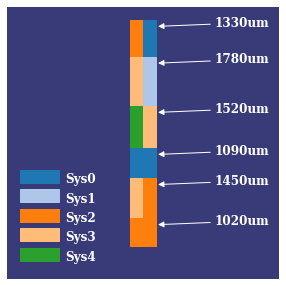

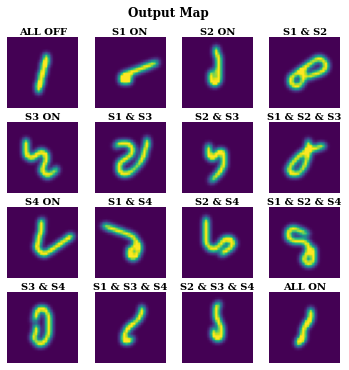

In [2]:
%run ./Numeric_Simulation_of_Material_Behavior.ipynb

In [3]:
# Sample Design
segment_lengths_ex_four_types = [938, 954, 1022, 843, 931, 722, 702, 655, 1066, 947]
segment_identities_ex_four_types = [[2,3,2,3,2,3,4,0,1,4],[4,4,3,1,3,4,4,1,3,2]]
sampleStrip = ActuatorStrip(segment_lengths_ex_four_types, segment_identities_ex_four_types, four_t_rocs, four_t_ctls)
cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")

### Multi-Objective Optimization Loss Function

$Loss = 5000 * (number\_of\_digits\_formed) * \sum_{i = 0}^{i = 9}[1.001 - (score\_for\_digit\_i)]$

This loss function computes the **diversity** and the **similarity to real digits** for the digits formed. Designs that outputs images resembling a larger number of high-quality digits are more likely to be preserved.

In [4]:
def loss_on_dig_sim_var_v2(strip, rotation = 20):
    """
    - loss on digit similarity and variety
    - default 20 rotations
    - Final design score list would be stored in a np array, documenting the max score for each digit.
    - Reconsider np.log as log would greatly lock into one design for a perfect 1 or 7, as log(1-1) = -inf
    
    The loss is then calculated by the following:
    
        digits_for_score = np.log(1 - digit_recs) * 5000 * digits_form)
        loss = np.sum(digits_for_score)

    Where we're taking the log of each value's distance against one, and scaling with the digit numbers that it can form.
    For design that can form more digit number and higher similairy, they can get lower loss.
    """
    strip.analysis(rotation = rotation); output = strip.selected
    dig_score = np.zeros(shape=(10, ))
    
    if output.keys():
        for i in output.keys():
            dig_score[i] = output[i]["score"] 
#     did 1.001 - dig_score as -inf often appears when 1 is in dig_score
    loss = np.sum(np.log(1.001 - dig_score) * 5000 * np.count_nonzero(dig_score))
    
    return loss

loss_on_dig_sim_var_v2(sampleStrip, rotation = 4) # -2080099.4708855439 if 0, messed up, restart kernal

-2275695.1417187443

### Updated Mutation Function controlling fabrication complexity

In [5]:
def fab_steps_strip_requires(identities):
    top_steps = np.size(np.unique(identities[0]))
    bottom_steps = np.size(np.unique(identities[1]))
    return top_steps + bottom_steps                    

def sp_mutation_maxfab_v1(parent_strip, max_segments, min_segment_length,\
                          max_segment_length, max_fab_steps, rocs, ctls, num_actuator_types):
    """
    - single parent mutation
    - v1 seems to be unable to produce new identities
    - v2 now has 40% new identities chance, and can retain 80% of original genetic info
    """
    # 50% chance in length change
    if np.random.random() < .5:
#         print("length change")
        new_length = np.random.random(size = (max_segments, )) * (max_segment_length - min_segment_length) + min_segment_length
        offspring_strip = ActuatorStrip(new_length, parent_strip.identities, rocs, ctls) 
    # 50% chance in acutator change, mutates 50% of identities
    else:
#         print("idt change")
        satisfy_max_fab = False
        while satisfy_max_fab == False:
            identities_mutation_rate = .5
            sz = int(np.floor(len(parent_strip.identities[0]) * identities_mutation_rate))
            new_identities = copy.deepcopy(parent_strip.identities)
            for i in range(2):
                gene_num = np.random.choice(len(parent_strip.identities[0]), size=(sz,), replace = False)
                new_genes = np.random.choice(num_actuator_types + 1, size = (sz,))
                for j in range(sz): new_identities[i][gene_num[j]] = new_genes[j] 
            if (fab_steps_strip_requires(new_identities) <= max_fab_steps):
                satisfy_max_fab = True
        offspring_strip = ActuatorStrip(parent_strip.segment_lengths, new_identities, rocs, ctls) 

        
    
    return offspring_strip

### Mutation Function

We used the **single-parent mutation method** where the genetic information of each descendant come from a single survived design from previous selection. During mutation, each design has a fifty percent chance to randomly update the strip segment lengths, preserving the actuator pattern information; each design also has a fifty percent chance of mutating the actuator pattern, where we randomly mutate half of the pattern. Each survivor design generates four descendants, so the population returns to its original size after every round of selection and mutation. 

In [6]:
def sp_mutation_v2(parent_strip, max_segments, min_segment_length,\
                   rocs, ctls, num_actuator_types):
    """
    - single parent mutation
    - v1 seems to be unable to produce new identities
    - v2 now has 40% new identities chance, and can retain 80% of original genetic info
    """
    # 50% chance in length change
    if np.random.random() < .5:
#         print("length change")
        new_length = np.random.random(size = (max_segments, )) * min_segment_length + min_segment_length
        offspring_strip = ActuatorStrip(new_length, parent_strip.identities, rocs, ctls) 
    # 50% chance in acutator change, mutates 50% of identities
    else:
#         print("idt change")
        identities_mutation_rate = .5
        sz = int(np.floor(len(parent_strip.identities[0]) * identities_mutation_rate))
        new_identities = copy.deepcopy(parent_strip.identities)
        for i in range(2):
            gene_num = np.random.choice(len(parent_strip.identities[0]), size=(sz,), replace = False)
            new_genes = np.random.choice(num_actuator_types + 1, size = (sz,))
            for j in range(sz): new_identities[i][gene_num[j]] = new_genes[j] 
        offspring_strip = ActuatorStrip(parent_strip.segment_lengths, new_identities, rocs, ctls) 
    
    return offspring_strip

### Combined Genetic Algorithm

In [7]:
def strip_optimizer_gen_alg_v3(rocs, ctls, loss_function, mutation_function, save_filename,\
                               max_segments = 6, min_segment_length = 600,\
                               max_segment_length = 2000, max_fab_steps = 6,\
                               population_size = 20, generation_limit = 10):
    """
    Genetic Algorithm for Strip Optimizer
        1. Creates 100 (or 20 for speed) different random initial design.
        2. Score them based on the loss function and get a sum of pupulation score.
        3. Kill 80% of the population who has score in the last 80%.
        4. Mutate the survivor and rescore them.
        5. Goes on and on and on until reaches generation limit
    """        
    def plot_best_fives(population_loss, strip_population, SAVE = False):
        """
        plots 5 best strip design for overall visualization
        """
        best5s = np.argsort(population_loss)[:5]
        for best_num in np.flip(best5s):
                best_strip = strip_population[best_num]
                print("Actuator segments are " + str(best_strip.identities))
                print("Segment lengths are " + str(best_strip.segment_lengths))
                print("Loss is " + str(population_loss[best_num]))
#                 best_strip.plot_input_and_all(rotation = 20, save = False)
                best_strip.plot_input_and_selected(rotation = 20, save = SAVE)

    def save_best_tens(filename, mode, population_loss, strip_population, gen):
        """
        save 10 best strip design of each generation.
        """
        with open(filename, mode) as f:
            f.write("Generation {}\n".format(gen))
            best10s = np.argsort(population_loss)[:10]
            for best_num in np.flip(best10s):
                    best_strip = strip_population[best_num]
                    formed = list(best_strip.selected.keys())
                    f.write("Segments: {}\nIdentities: {}\nFormed: {}\n\n".format(str(best_strip.segment_lengths),str(best_strip.identities),str(formed)))

    itr = 0; num_actuator_types = len(rocs[0][0]) - 1
    
    loss_trajectory = np.zeros(shape = (generation_limit, population_size))
    
    # generate initial population
    population_lengths = np.random.random(size = (population_size, max_segments)) * (max_segment_length - min_segment_length) + min_segment_length
    population_identities = np.random.randint(0, high = (num_actuator_types + 1), size = (population_size, 2, max_segments))
    # Swapping out non-fabricat-able
    for i in range(population_size):
        found_fabbable = False
        while found_fabbable == False:
            population_identities[i] = np.random.randint(0, high = (num_actuator_types + 1), size = (2, max_segments))
            if fab_steps_strip_requires(population_identities[i]) <= max_fab_steps:
                found_fabbable = True
               
    strip_population = [ActuatorStrip(population_lengths[num], population_identities[num], four_t_rocs, four_t_ctls) for num in range(population_size)]
    [strip.generate_curves() for strip in strip_population]
    population_loss = [loss_function(strip) for strip in strip_population]
    loss_trajectory[itr:len(population_loss)] = population_loss
#     [strip.save_imgs() for strip in strip_population]

    # plot 5 best individuals for visualization
    plot_best_fives(population_loss, strip_population, SAVE = False)
    # save 5 best individuals
#     save_best_tens(save_filename, "w", population_loss, strip_population, itr)
    
    while itr < generation_limit:
        itr += 1
        # evolution and mutation
        print("Generation - {}".format(itr))

        # kills 80% of the population
        survivors = np.argsort(population_loss)[:int(np.floor(population_size/5))]
        print("Survivors: " + str(survivors))
        print("Survivor loss: " + str([population_loss[i] for i in survivors]))
        # mutation and creates 4 offspring for each survivor
        new_population = [mutation_function(strip_population[survivor_id], max_segments, min_segment_length,\
                          max_segment_length, max_fab_steps, 
                          rocs, ctls, num_actuator_types) for survivor_id in survivors for _ in range(4)]
        [strip.generate_curves() for strip in new_population]
        # Add survivors to new population
        [new_population.append(strip_population[survivor_id]) for survivor_id in survivors];
        new_loss = [loss_function(strip) for strip in new_population]
        loss_trajectory[itr:len(new_loss)] = new_loss
#         [strip.save_imgs() for strip in new_population]

        # plot 5 best individuals for visualization
        if itr == generation_limit:
            plot_best_fives(new_loss, new_population, SAVE = True)
        else:
            plot_best_fives(new_loss, new_population, SAVE = False)
            
#         save_best_tens(save_filename, "a+", new_loss, new_population, itr)
        print("delta population loss: %.4f"%(np.sum(new_loss) - np.sum(population_loss)))
        population_loss = new_loss; strip_population = new_population
        
    return loss_trajectory
        

Actuator segments are [[0 4 3 0 4 3]
 [1 0 2 2 2 0]]
Segment lengths are [ 628.83880451  691.42082617  910.76066641  904.43563928  727.92092009
 1191.12543345]
Loss is -1062471.4013197902


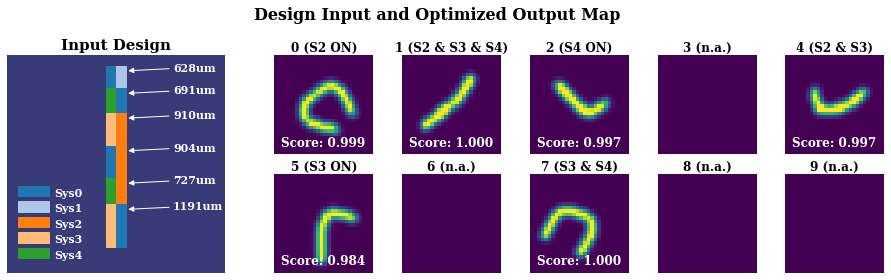

Actuator segments are [[2 4 2 2 4 4]
 [2 1 1 2 1 4]]
Segment lengths are [1705.56933441 1257.97893459 1177.76015754 1619.50576739 1110.95459075
 1976.68655493]
Loss is -1131145.2487688859


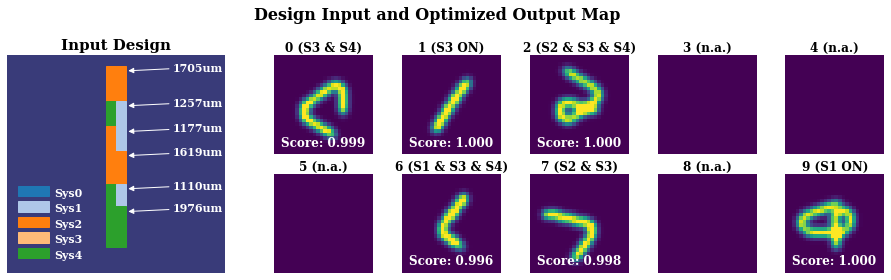

Actuator segments are [[1 1 4 1 3 3]
 [4 4 4 2 2 1]]
Segment lengths are [1489.70621324  699.34166455 1628.09323215 1469.975176   1261.84269299
 1191.32906048]
Loss is -1371175.338292958


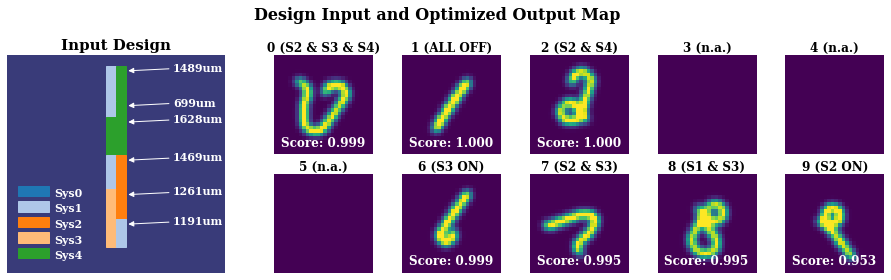

Actuator segments are [[2 2 3 2 0 2]
 [1 1 4 1 1 0]]
Segment lengths are [ 626.57709726 1361.29056869 1733.57480639 1527.21421496 1186.76221841
  977.43437984]
Loss is -1711447.8914414723


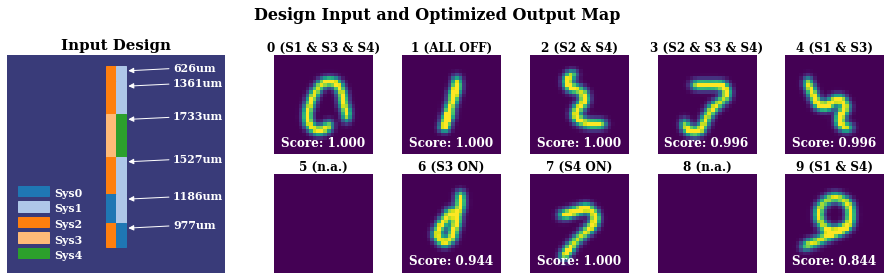

Actuator segments are [[3 0 3 1 3 2]
 [1 2 1 2 1 2]]
Segment lengths are [1824.92194009  975.42483141 1168.1569941  1442.11745696 1143.96477412
 1196.02486414]
Loss is -1737676.6738320042


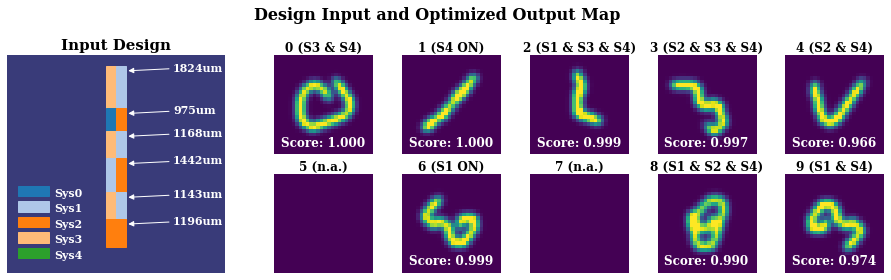

Evolution 1
Survivors: [14  3  8  6]
Survivor loss: [-1737676.6738320042, -1711447.8914414723, -1371175.338292958, -1131145.2487688859]
Actuator segments are [[2 2 3 2 0 2]
 [1 1 4 1 1 0]]
Segment lengths are [ 926.49661792 1707.11432857 1293.83327578 1084.44021298 1708.33121499
 1421.35624179]
Loss is -1499770.7475790568


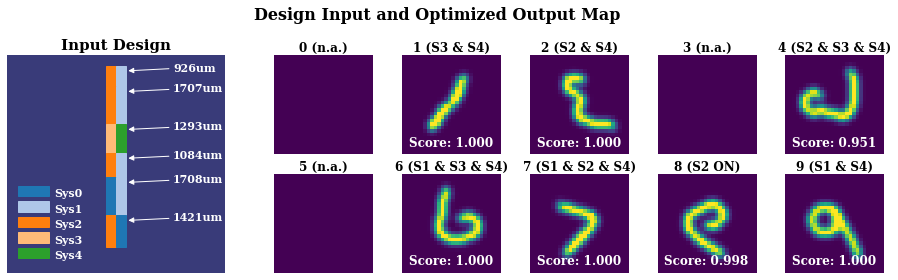

Actuator segments are [[1 3 4 3 3 3]
 [2 4 4 2 3 4]]
Segment lengths are [1489.70621324  699.34166455 1628.09323215 1469.975176   1261.84269299
 1191.32906048]
Loss is -1600626.7844211315


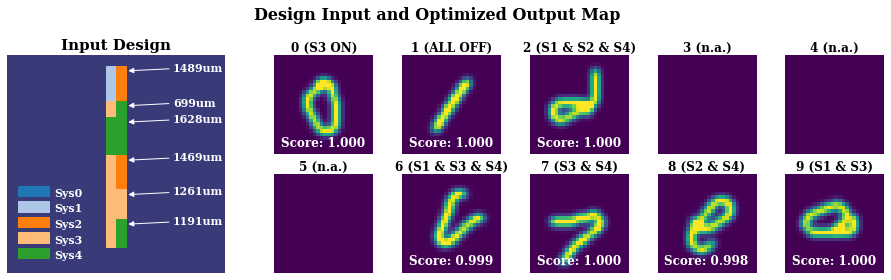

Actuator segments are [[2 2 3 2 0 2]
 [1 1 4 1 1 0]]
Segment lengths are [ 626.57709726 1361.29056869 1733.57480639 1527.21421496 1186.76221841
  977.43437984]
Loss is -1711447.8914414723


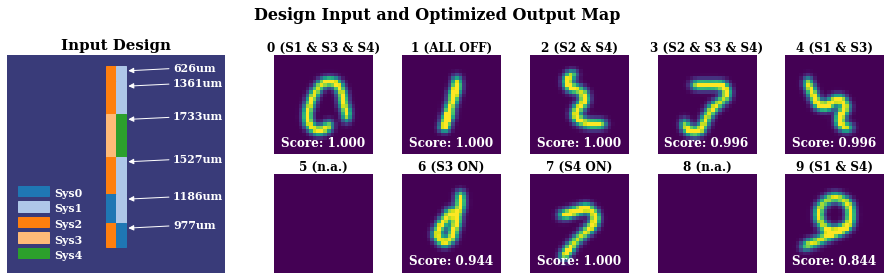

Actuator segments are [[3 0 3 1 3 2]
 [1 2 1 2 1 2]]
Segment lengths are [1824.92194009  975.42483141 1168.1569941  1442.11745696 1143.96477412
 1196.02486414]
Loss is -1737676.6738320042


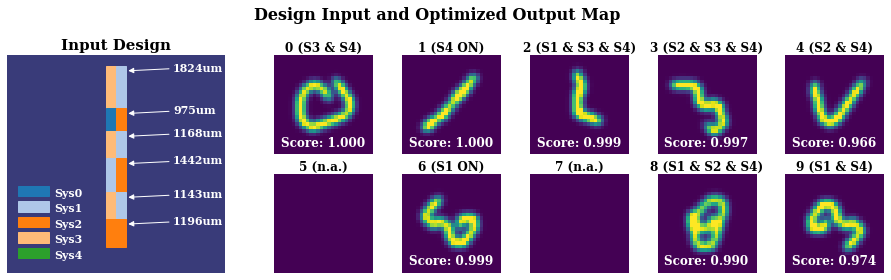

Actuator segments are [[3 0 3 1 3 2]
 [1 2 1 2 1 2]]
Segment lengths are [1221.47919536 1025.3070837  1314.01532914 1514.21131988 1366.32812899
 1978.80620626]
Loss is -1741859.177648781


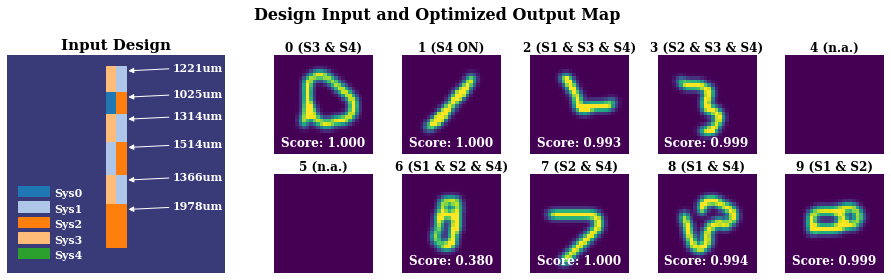

delta population loss: -7213665.9455
Evolution 2
Survivors: [ 2 16 17  8]
Survivor loss: [-1741859.177648781, -1737676.6738320042, -1711447.8914414723, -1600626.7844211315]


KeyboardInterrupt: 

In [19]:
history = strip_optimizer_gen_alg_v3(four_t_rocs, four_t_ctls,\
                                     loss_on_dig_sim_var_v2,\
                                     sp_mutation_maxfab_v1,\
                                     "test01.txt",\
                                     max_segments = 6, min_segment_length = 600,\
                                     max_segment_length = 2000, max_fab_steps = 6,\
                                     population_size = 20, generation_limit = 10)